# 社群媒體分析期末專案-第4組
## 專案主題：PTT網友對於長榮年終事件的討論
成員：M094020038 李佳蓉、M094020039 邢學皓 、M104020013 黃威凱、M104020048 顏宏任

## 大綱
1. 動機與分析目的
2. 分析方向及工具
3. 基本資料介紹
4. 資料前處理
5. 文件分類
6. 訓練 LDA 模型
  + 查看LDA主題代表字
  + 查看LDA模型指標
  + 透過指標找出最佳主題數
  + 產生 LDAvis 結果
  + 查看 Document 主題時間上分佈
7. 基本圖學理論&igraph
8. 社會網路分析
  + 結論

## 1.動機與分析目的

長榮海運在2021/12/30發放年終，因此上了新聞熱搜部分，為了探究這次事件的討論主題及三間海運間的關聯，因此我們針對這次PTT上網友的討論進行了本次的研究及分析。

## 2.分析方向及工具
1. 主題模型，用來分析文章主題的類別。
2. 基本圖學，可以用來找出人物之間的關係圖。
3. 社會網路分析，透過LDA為資料進行的主題分析，再以不同角度對社群進行篩選分析。

## 3.基本資料介紹
* 資料來源：文字平台 PTT Gossip八卦板、job版、salary版、stock版
* 資料集：長榮_articleMetaData.csv、長榮_articleReviews.csv
* 關鍵字：長榮、陽明、萬海
* 排除關鍵字：大學、酒店、台糖、航空、桂冠大飯店
* 資料時間：2021-12-29 ～ 2022-01-05
* 資料量： 320 篇文章、20933 個留言

## 4. 載入套件

In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import numpy as np
import jieba.analyse
import IPython
from pyvis.network import Network
from itertools import permutations
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import time
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

# 設定圖的字體大小
font = {'size':14}
matplotlib.rc('font', **font)

# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 4.1 資料前處理
匯入「長榮海運0109_articleMetaData.csv」、「長榮海運0109_articleReviews.csv'」檔案，並且清理文句。

In [3]:
#匯入資料
MetaData = pd.read_csv('./raw_data/長榮海運0109_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/長榮海運0109_articleReviews.csv', encoding='UTF-8')

In [4]:
# 合併每篇文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent", "cmtPoster", "cmtStatus", "cmtContent"]], how = "left", on = 'artUrl')

In [5]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021/12/29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,以前有幹過10個月保全來講一下\n\n我那時候的薪資單，機動的話錢會再多一點\nhttps:...
1,[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021/12/29,15:01:11,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,Aliensoul,Gossiping,321,48,142,1.媒體來源:\nETtoday新聞雲\n\n2.記者署名:\n記者曾筠淇／綜合報導\n\n...
2,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021/12/29,17:26:21,https://www.ptt.cc/bbs/Gossiping/M.1640798784....,gourmand,Gossiping,26,6,1,每次看到這個財經什麼美的出來講長榮就有氣\n\n講得有道理或符應後續事實發展也就算了\n但偏...


In [6]:
print(Reviews.shape)
Reviews.head(3)

(21033, 13)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,cmtPoster,cmtStatus,cmtContent
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021/12/29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,:都是機歪人才在搞機歪事,maltum,推,:都是機歪人才在搞機歪事
1,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021/12/29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,:知道會一直換的，還會標是想賭一把？,Swando,→,:知道會一直換的，還會標是想賭一把？
2,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021/12/29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,:標到就有錢阿反正案子合約到期或解約，場,zeumax,推,:標到就有錢阿反正案子合約到期或解約，場


In [7]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除|新聞記者|新聞|綜合報導)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('\n', ',', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

In [8]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': MetaData.groupby('artDate').size().index,
    'count': MetaData.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

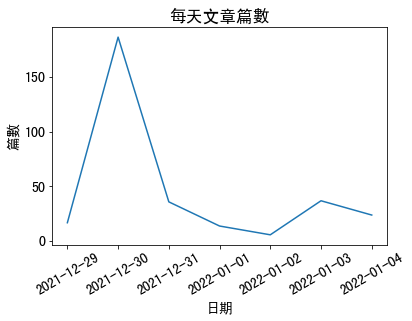

In [9]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每天文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

### 4.2 Jieba中文斷詞、匯入字典

斷詞引擎設定：使用 Jieba 當作斷詞系統。<br>

Jieba 原先內建為簡體字字典，因此我們匯入繁體字典，斷詞結果會比較好。<br>
另外，在一些特殊主題裡，會有獨特的專有名詞，因此我們需要加入這些字詞進去。<br>
兩種方式：1.匯入檔案 2.參數形式手動加入

以下用匯入檔案的方式：

In [10]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
jieba.set_dictionary('./dict/dict.txt') 

# 自定義辭典
print("--> 匯入自定義字典，這裡匯入三個海運名字")
jieba.load_userdict('./dict/長榮.txt')

Building prefix dict from /home/zackary/Social/final_project/dict/dict.txt ...
Loading model from cache /tmp/jieba.u13255f09e2fe2cb20eb18c0a8c7d4851.cache


--> 匯入自定義字典，這裡匯入三個海運名字


Loading model cost 0.576 seconds.
Prefix dict has been built successfully.


In [11]:
# 資料進行斷詞，為list的格式
data = MetaData[['artUrl','sentence']].astype(str)
token_df = data.assign(wordlist = data['sentence'].apply(jieba.lcut))

print("資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)")
token_df.head(3)

資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)


,artUrl,sentence,wordlist
0,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,"以前有幹過,個月保全來講一下,,我那時候的薪資單，機動的話錢會再多一點,,管委會一個月給多少...","[以前, 有, 幹過, ,, 個, 月, 保全, 來講, 一下, ,, ,, 我, 那, 時..."
1,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,",.:,,雲,,,.:,記者曾筠淇／,,,.:,「沒台灣，世界會停止運轉！」她列超狂,實例網...","[,, ., :, ,, ,, 雲, ,, ,, ,, ., :, ,, 記者, 曾筠, 淇..."
2,https://www.ptt.cc/bbs/Gossiping/M.1640798784....,"每次看到這個財經什麼美的出來講長榮就有氣,,講得有道理或符應後續事實發展也就算了,但偏偏經常...","[每次, 看到, 這個, 財經, 什麼, 美, 的, 出來, 講, 長榮, 就, 有氣, ,..."


### 4.3 去除停用字

為了提高準確度，我們會將停用字移除，例如：空格、標點符號、語助詞...等。<br>
兩種方式： 1.匯入檔案 2.參數形式手動加入

以下使用匯入檔案的方式：

In [12]:
stopwords = []

#匯入檔案
with open(f'./dict/stopwords.txt','r',encoding="utf-8") as f:
    stopwords = f.read().splitlines() #移除換行符號\n

print("stropwords儲存為list形式，前幾個為：")
stopwords[:15]

stropwords儲存為list形式，前幾個為：


['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”']

In [13]:
# 移除停用字的 function
def remove_stop(listt):
    result = [re.sub(r'\d|-', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result

In [14]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(3)

remove_stopwords 為 wordlist 移除停用字後的結果：


,artUrl,sentence,wordlist,remove_stopwords
0,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,"以前有幹過,個月保全來講一下,,我那時候的薪資單，機動的話錢會再多一點,,管委會一個月給多少...","[以前, 有, 幹過, ,, 個, 月, 保全, 來講, 一下, ,, ,, 我, 那, 時...","[以前, 幹過, 保全, 薪資單, 機動, 錢會, 一點, 管委會, 給多少, 案場, 物業..."
1,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,",.:,,雲,,,.:,記者曾筠淇／,,,.:,「沒台灣，世界會停止運轉！」她列超狂,實例網...","[,, ., :, ,, ,, 雲, ,, ,, ,, ., :, ,, 記者, 曾筠, 淇...","[記者, 曾筠, 台灣, 世界, 停止, 運轉, 超狂, 實例, 網跪, 隱藏, 冠軍, 長..."
2,https://www.ptt.cc/bbs/Gossiping/M.1640798784....,"每次看到這個財經什麼美的出來講長榮就有氣,,講得有道理或符應後續事實發展也就算了,但偏偏經常...","[每次, 看到, 這個, 財經, 什麼, 美, 的, 出來, 講, 長榮, 就, 有氣, ,...","[看到, 財經, 長榮, 有氣, 講得, 道理, 符應, 後續, 事實, 發展, 未必, 八..."


## 5.文件分類

In [15]:
temp = MetaData.copy()

In [16]:
temp['sentence'] = temp['artTitle'] + temp['sentence']

In [17]:
temp = temp.dropna() #去掉空白欄位
dataclass = temp[['sentence','artUrl']]
dataclass.head(3)

,sentence,artUrl
0,"Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了以前有幹過,個月保全來講一下,,我那時...",https://www.ptt.cc/bbs/Gossiping/M.1640788462....
1,"[新聞]「沒台灣，世界會停止運轉！」她列超狂5,.:,,雲,,,.:,記者曾筠淇／,,,.:...",https://www.ptt.cc/bbs/Gossiping/M.1640790075....
2,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5每次看到這個財經什麼美的出來講長榮就有氣...,https://www.ptt.cc/bbs/Gossiping/M.1640798784....


In [18]:
dataclass = dataclass[['sentence','artUrl']].explode("sentence")
dataclass['document'] = range(0, len(data))
dataclass.head(3)

,sentence,artUrl,document
0,"Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了以前有幹過,個月保全來講一下,,我那時...",https://www.ptt.cc/bbs/Gossiping/M.1640788462....,0
1,"[新聞]「沒台灣，世界會停止運轉！」她列超狂5,.:,,雲,,,.:,記者曾筠淇／,,,.:...",https://www.ptt.cc/bbs/Gossiping/M.1640790075....,1
2,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5每次看到這個財經什麼美的出來講長榮就有氣...,https://www.ptt.cc/bbs/Gossiping/M.1640798784....,2


In [19]:
# 斷詞
def load_stop_words(path):
    with open(path) as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

# 這裡會跑比較久
stop_path = 'dict/stopwords.txt'
user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
dataclass['clean_txt'] = dataclass.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
dataclass.head(5)

,sentence,artUrl,document,clean_txt
0,"Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了以前有幹過,個月保全來講一下,,我那時...",https://www.ptt.cc/bbs/Gossiping/M.1640788462....,0,新聞 大樓 保全 年輕人 網見 月薪 全懂 以前 過個 保全 薪資單 機動 錢會 一點 管委...
1,"[新聞]「沒台灣，世界會停止運轉！」她列超狂5,.:,,雲,,,.:,記者曾筠淇／,,,.:...",https://www.ptt.cc/bbs/Gossiping/M.1640790075....,1,新聞 台灣 世界 停止 運轉 超狂 記者 曾筠 台灣 世界 停止 運轉 超狂 實例 網跪 隱...
2,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5每次看到這個財經什麼美的出來講長榮就有氣...,https://www.ptt.cc/bbs/Gossiping/M.1640798784....,2,新聞 台灣 世界 停止 運轉 超狂 看到 財經 長榮 有氣 講得 道理 符應 後續 事實 發...
3,"[新聞]超爽！長榮海運年終獎金落袋狂撒40個月 ,,,.:,中時,,,.:,黃琮淵,,,.:...",https://www.ptt.cc/bbs/Gossiping/M.1640824950....,3,新聞 超爽 長榮海運 年終 獎金 落袋 狂撒 時黃琮 淵獨 超爽 長榮海運 年終 獎金 落袋...
4,"[問卦]你各位年終幾個月（補一下現在,長榮職缺薪資）,,今天最大條，就是長榮年終大爆發,個月...",https://www.ptt.cc/bbs/Gossiping/M.1640826743....,4,問卦 年終 幾個 現在 長榮 職缺 薪資 最大條 長榮 年終 爆發 今年 獲利 滿滿 卡船 ...


In [20]:
# 把字詞斷開，待會情緒分析
token_df1 = dataclass[['document','clean_txt']]
token_df1["word"] = dataclass["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df1 = token_df1[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df1.head(5)

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,document,word
0,0,新聞
1,0,大樓
2,0,保全
3,0,年輕人
4,0,網見


### 5.1 套入情緒

In [21]:
filepath = ['ntusd-negative','ntusd-positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split("\n"),file])

d_liwc

df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc.head(3)

,word,sentiments
0,幹,ntusd-negative
1,一下子爆發,ntusd-negative
2,一下子爆發的一連串,ntusd-negative


In [22]:
#合併至斷開後的 token_df1 & df_liwc -> 合併到 senti_count(下方右圖)
# 統計文章情緒
senti_df = pd.merge(token_df1, df_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['ntusd-positive'] >= senti_count['ntusd-negative'], 'pos','neg')
senti_count.head(3)

,document,ntusd-negative,ntusd-positive,label
0,0,27.0,10.0,neg
1,1,20.0,15.0,neg
2,2,29.0,17.0,neg


In [23]:
# 合併到原本的資料集
data_senti = pd.merge(dataclass, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,sentence,artUrl,document,clean_txt,label
0,"Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了以前有幹過,個月保全來講一下,,我那時...",https://www.ptt.cc/bbs/Gossiping/M.1640788462....,0,新聞 大樓 保全 年輕人 網見 月薪 全懂 以前 過個 保全 薪資單 機動 錢會 一點 管委...,neg
1,"[新聞]「沒台灣，世界會停止運轉！」她列超狂5,.:,,雲,,,.:,記者曾筠淇／,,,.:...",https://www.ptt.cc/bbs/Gossiping/M.1640790075....,1,新聞 台灣 世界 停止 運轉 超狂 記者 曾筠 台灣 世界 停止 運轉 超狂 實例 網跪 隱...,neg
2,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5每次看到這個財經什麼美的出來講長榮就有氣...,https://www.ptt.cc/bbs/Gossiping/M.1640798784....,2,新聞 台灣 世界 停止 運轉 超狂 看到 財經 長榮 有氣 講得 道理 符應 後續 事實 發...,neg
3,"[新聞]超爽！長榮海運年終獎金落袋狂撒40個月 ,,,.:,中時,,,.:,黃琮淵,,,.:...",https://www.ptt.cc/bbs/Gossiping/M.1640824950....,3,新聞 超爽 長榮海運 年終 獎金 落袋 狂撒 時黃琮 淵獨 超爽 長榮海運 年終 獎金 落袋...,pos
4,"[問卦]你各位年終幾個月（補一下現在,長榮職缺薪資）,,今天最大條，就是長榮年終大爆發,個月...",https://www.ptt.cc/bbs/Gossiping/M.1640826743....,4,問卦 年終 幾個 現在 長榮 職缺 薪資 最大條 長榮 年終 爆發 今年 獲利 滿滿 卡船 ...,pos


### 5.2 一些統計資訊

In [24]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df1, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

## 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

,label,word,size
1204,neg,壹週刊,31
3353,neg,航運,34
3397,neg,萬元,36
2912,neg,知道,36
3666,neg,貨櫃,39


### 5.3 切割 training / testing set

In [25]:
# 把整個資料集七三切
dtf_train, dtf_test = train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2022)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

#### 5.3.1 各個資料集切分的比例

In [26]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
pos    58.4375
neg    30.9375
neu    10.6250
Name: label, dtype: float64

train percentage :
pos    58.482143
neg    30.803571
neu    10.714286
Name: label, dtype: float64

test percentage :
pos    58.333333
neg    31.250000
neu    10.416667
Name: label, dtype: float64


#### 5.3.2 建模

In [27]:
corpus = dtf_train["clean_txt"]

In [28]:
# 建模
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):

    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)

    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)

    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)

    end = time.time()
    print(f"time costing: {end - start}")

    if return_classifier:
        return predicted, predicted_prob, classifier
    else:
        return predicted, predicted_prob

In [29]:
# 畫圖 (confusion matrix)
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob,
                                multi_class="ovr")

    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 

    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

    return Accuracy, AUC, roc_auc_dict

In [30]:
# 定義 vectorizer
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

# 定義 classifier
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

# 定義 training / testing set
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 5.4 Apply

#### 5.4.1 CV + logistic regression

model type: CV + logistic regression
time costing: 0.38726377487182617
Accuracy: 0.64
Auc: 0.72
Detail:
              precision    recall  f1-score   support

         neg       0.61      0.37      0.46        30
         neu       0.25      0.10      0.14        10
         pos       0.66      0.88      0.75        56

    accuracy                           0.64        96
   macro avg       0.51      0.45      0.45        96
weighted avg       0.60      0.64      0.60        96



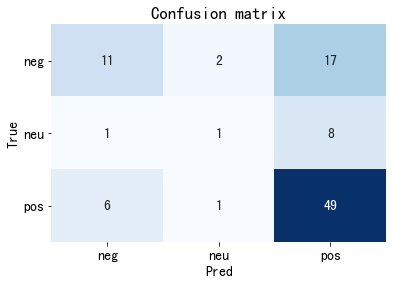

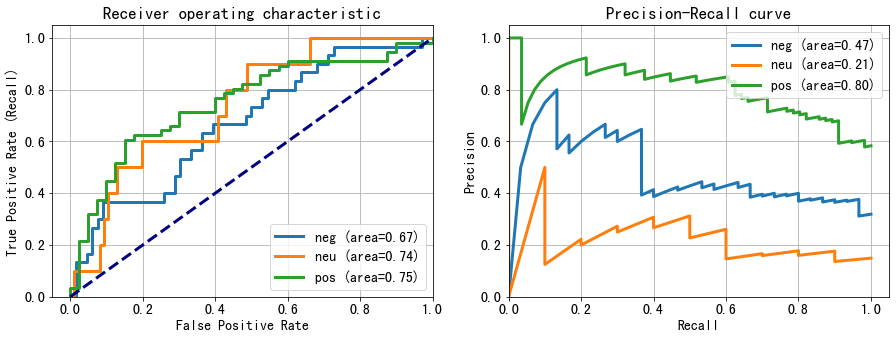

In [31]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")

# 訓練模型 -> CV + logistic regression
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 5.4.2 TF-IDF + logistic regression

model type: TF-IDF + logistic regression
time costing: 0.14519429206848145
Accuracy: 0.59
Auc: 0.72
Detail:
              precision    recall  f1-score   support

         neg       1.00      0.03      0.06        30
         neu       0.00      0.00      0.00        10
         pos       0.59      1.00      0.74        56

    accuracy                           0.59        96
   macro avg       0.53      0.34      0.27        96
weighted avg       0.66      0.59      0.45        96



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


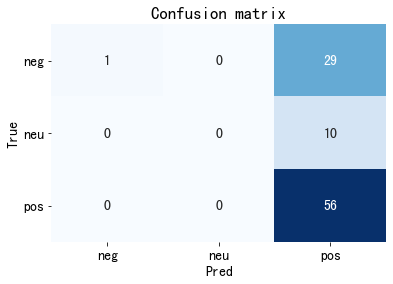

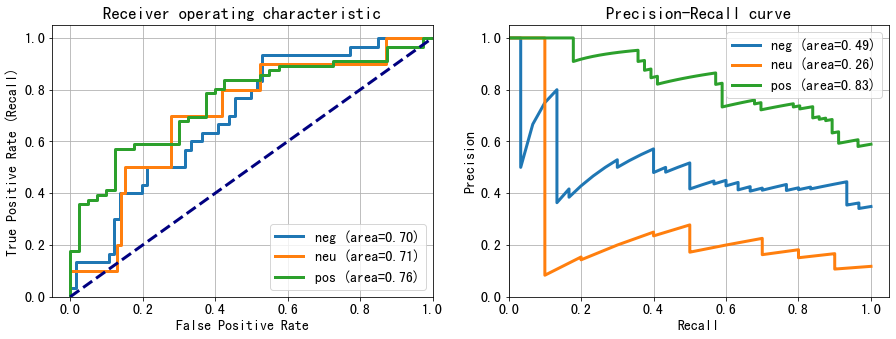

In [32]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型 -> TF-IDF + logistic regression
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 5.4.3 CV + SVC

model type: CV + SVC
time costing: 0.26322507858276367
Accuracy: 0.6
Auc: 0.62
Detail:
              precision    recall  f1-score   support

         neg       1.00      0.07      0.12        30
         neu       0.00      0.00      0.00        10
         pos       0.60      1.00      0.75        56

    accuracy                           0.60        96
   macro avg       0.53      0.36      0.29        96
weighted avg       0.66      0.60      0.47        96



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


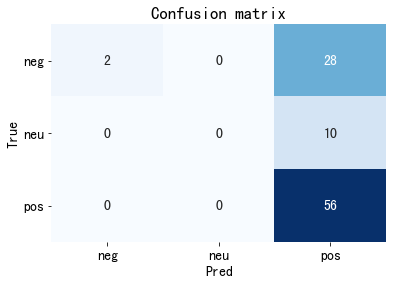

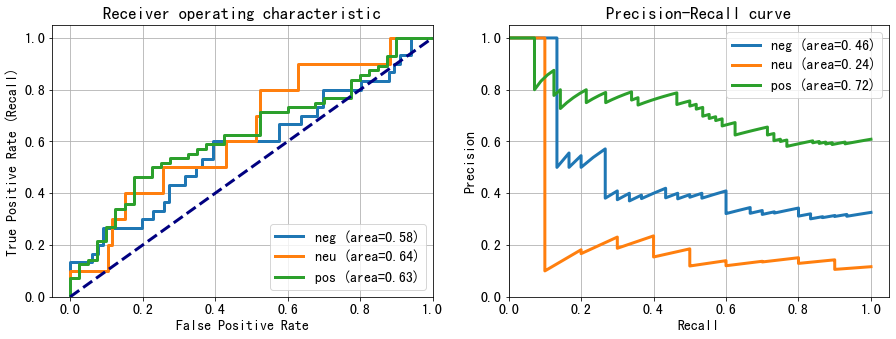

In [33]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果 -> CV + SVC
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 5.4.4 TF-IDF + SVC

model type: TF-IDF + SVC
time costing: 0.26662421226501465
Accuracy: 0.59
Auc: 0.71
Detail:
              precision    recall  f1-score   support

         neg       1.00      0.03      0.06        30
         neu       0.00      0.00      0.00        10
         pos       0.59      1.00      0.74        56

    accuracy                           0.59        96
   macro avg       0.53      0.34      0.27        96
weighted avg       0.66      0.59      0.45        96



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


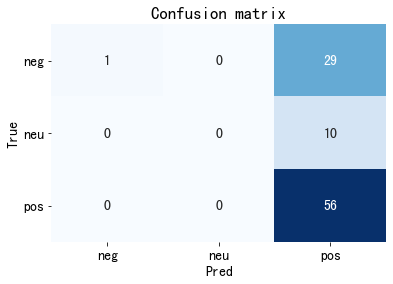

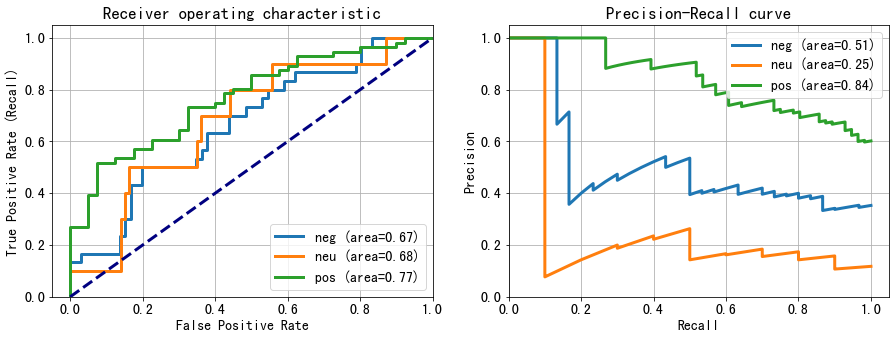

In [34]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")

# 訓練模型 -> TF-IDF + SVC
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 5.4.5 CV + RandomForest

model type: CV + RandomForest
time costing: 0.30472874641418457
Accuracy: 0.58
Auc: 0.61
Detail:
              precision    recall  f1-score   support

         neg       0.50      0.07      0.12        30
         neu       0.00      0.00      0.00        10
         pos       0.59      0.96      0.73        56

    accuracy                           0.58        96
   macro avg       0.36      0.34      0.28        96
weighted avg       0.50      0.58      0.46        96



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


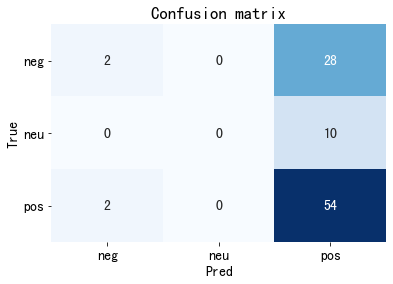

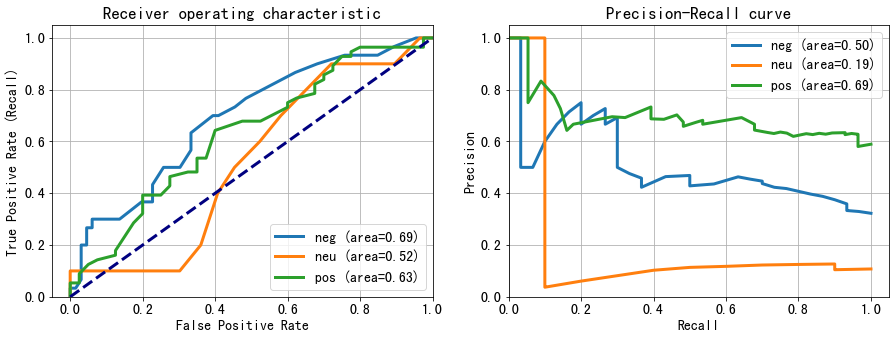

In [35]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")

# 訓練模型 -> CV + RandomForest
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)

# 查看模型訓練結果 
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 5.4.6 TF-IDF + RandomForest

model type: TF-IDF + RandomForest
time costing: 0.30089497566223145
Accuracy: 0.62
Auc: 0.69
Detail:
              precision    recall  f1-score   support

         neg       0.83      0.17      0.28        30
         neu       0.00      0.00      0.00        10
         pos       0.62      0.98      0.76        56

    accuracy                           0.62        96
   macro avg       0.48      0.38      0.35        96
weighted avg       0.62      0.62      0.53        96



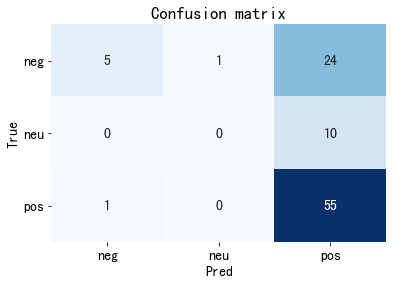

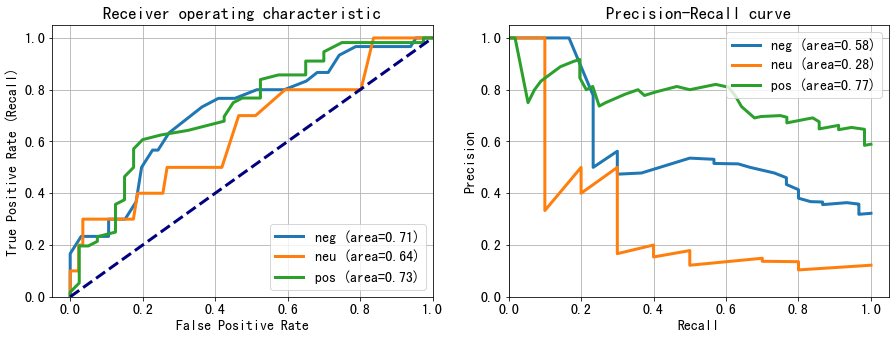

In [36]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")

# 訓練模型 -> TF-IDF + RandomForest
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)

# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

## 6. 訓練 LDA 模型

將文章斷詞結果儲存為 list 資料形態，一篇文章為一個 list ，其中 element 為詞彙。

In [37]:
token_data = token_df['remove_stopwords'].tolist()

In [38]:
for i in range(0,3):
    print("第 " + str(i+1) + " 篇文章前10個字：")
    for j in range(0,10):
        print(token_data[i][j], end=' ')
    print('\n')

第 1 篇文章前10個字：
以前 幹過 保全 薪資單 機動 錢會 一點 管委會 給多少 案場 

第 2 篇文章前10個字：
記者 曾筠 台灣 世界 停止 運轉 超狂 實例 網跪 隱藏 

第 3 篇文章前10個字：
看到 財經 長榮 有氣 講得 道理 符應 後續 事實 發展 



In [39]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(7734 unique tokens: ['一休', '一例', '一小時', '一年', '一種']...)


In [40]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 2), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2)]


In [41]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=6, # 生成幾個主題數
    random_state=2022, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

### 6.1 查看 LDA 主題代表字

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

In [42]:
# 每個主題重要的前20個關鍵字
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.023*"長榮" + 0.010*"陽明" + 0.008*"年終" + 0.007*"員工" + 0.006*"台灣"')
(1, '0.021*"年終" + 0.019*"長榮" + 0.017*"員工" + 0.013*"獎金" + 0.011*"公司"')
(2, '0.029*"年終" + 0.022*"員工" + 0.021*"陽明" + 0.018*"獎金" + 0.014*"長榮"')
(3, '0.012*"長榮" + 0.010*"年終" + 0.009*"員工" + 0.007*"獎金" + 0.005*"貨櫃"')
(4, '0.010*"台股" + 0.006*"指數" + 0.006*"一年" + 0.006*"長榮" + 0.006*"原文"')
(5, '0.008*"台灣" + 0.008*"資增" + 0.008*"券增" + 0.007*"忠良" + 0.006*"長榮"')


### 6.2 查看 LDA 模型指標
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [43]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -5.171266506009321


In [44]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.101821979989023


### 6.3 透過指標找出最佳主題數

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
這裡我們選擇主題數 3 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [45]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 2022,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-8.188409,3598.990897
1,4,-8.145038,3446.236264
2,6,-8.101796,3300.389049
3,8,-8.099834,3293.921969


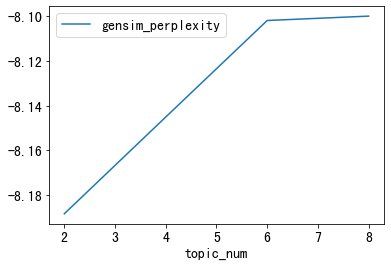

In [46]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-8.188409,3598.990897
1,4,-8.145038,3446.236264
2,6,-8.101796,3300.389049
3,8,-8.099834,3293.921969


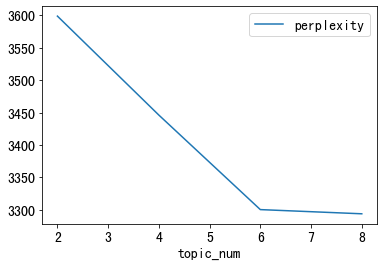

In [47]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

* 我們發現在主題數為6時呈現趨緩，因次以下將用主題數6進行分析

In [48]:
#生成模型 
ldamodel2 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=6, # 生成幾個主題數
    random_state=2022, # 亂數
    iterations = 2000,
    passes=5, # 模型訓練次數
)
# 1分鐘內跑完

In [49]:
# 每個主題重要的前20個關鍵字
topics = ldamodel2.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.023*"長榮" + 0.010*"陽明" + 0.008*"年終" + 0.007*"員工" + 0.006*"台灣" + 0.005*"公司" + 0.005*"大陸" + 0.005*"海運" + 0.004*"張數" + 0.004*"市場" + 0.004*"元大" + 0.004*"跨年" + 0.004*"中國" + 0.004*"名稱" + 0.003*"獲利"')
(1, '0.021*"年終" + 0.019*"長榮" + 0.017*"員工" + 0.013*"獎金" + 0.011*"公司" + 0.011*"今年" + 0.006*"長榮海運" + 0.005*"萬海" + 0.005*"船員" + 0.005*"陽明" + 0.004*"去年" + 0.004*"原文" + 0.004*"億元" + 0.004*"萬元" + 0.004*"現在"')
(2, '0.029*"年終" + 0.022*"員工" + 0.021*"陽明" + 0.018*"獎金" + 0.014*"長榮" + 0.013*"公司" + 0.008*"今年" + 0.007*"長榮海運" + 0.006*"獲利" + 0.005*"原文" + 0.005*"紅利" + 0.004*"表示" + 0.004*"貨櫃" + 0.004*"發放" + 0.004*"去年"')
(3, '0.012*"長榮" + 0.010*"年終" + 0.009*"員工" + 0.007*"獎金" + 0.005*"貨櫃" + 0.005*"市場" + 0.005*"海運" + 0.004*"公司" + 0.004*"陽明" + 0.004*"長榮海運" + 0.003*"今年" + 0.003*"入帳" + 0.003*"空櫃" + 0.003*"銀行" + 0.003*"最後"')
(4, '0.010*"台股" + 0.006*"指數" + 0.006*"一年" + 0.006*"長榮" + 0.006*"原文" + 0.006*"台積電" + 0.005*"聯電" + 0.005*"台灣" + 0.004*"現在" + 0.004*"大漲" + 0.004*"陽明" + 0.004*"二年" + 0.004*"獲利" + 0.004*"外資" + 0.004*

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：

+ 主題0：長榮股票資增
+ 主題1：長榮和陽明年終
+ 主題2：長榮和陽明指數漲幅
+ 主題3：長榮年終與獎金
+ 主題4：長榮、陽明、萬海員工比較輿論
+ 主題5：長榮、陽明海外市場談論


### 6.4 視覺化呈現

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 6個主題數，因此有6個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)


In [50]:
#生成模型 
ldamodel2 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=6, # 生成幾個主題數
    random_state=2022, # 亂數
    iterations = 2000,
    passes=5, # 模型訓練次數
)
# 1分鐘內跑完

In [52]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel2, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis.html')

#### 6.4.1 查看 Document 主題時間上分佈

使用模型分析我們的資料，取得每條新聞的主題分佈，選最大的設為此文章的主題。<br>
再根據時間來做分析，了解不同的時間點討論的主題大多為什麽，以比例的方式呈現。

In [53]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel2.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    doc_list.append(max_topic)

In [54]:
# 將結果放進 DataFrame裏
MetaData['topic'] = doc_list

In [55]:
# 將 artDate 轉換為 Python 日期時間
MetaData.artDate = pd.to_datetime(MetaData['artDate'])

In [56]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':MetaData.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
# date_topic.artDate.dt.to_period('M')：把日期按月份形式表示
date_topic = date_topic.groupby([date_topic.artDate.dt.to_period('D'),'topic']).sum().reset_index()
#date_topic = date_topic.groupby([date_topic.artDate.dt.to_period('M'),'topic']).sum().reset_index()



In [57]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2','topic3','topic4','topic5']
# 前面日期變period形式要把他變回timestamp形式 --> to_timestamp：以便於畫圖
date_df = date_df.set_index('artDate').to_timestamp()
date_df

,topic0,topic1,topic2,topic3,topic4,topic5
artDate,,,,,,
2021-12-29,5.0,1.0,4.0,0.0,4.0,3.0
2021-12-30,19.0,56.0,49.0,22.0,17.0,23.0
2021-12-31,3.0,12.0,7.0,4.0,4.0,6.0
2022-01-01,0.0,4.0,5.0,1.0,2.0,2.0
2022-01-02,2.0,1.0,0.0,1.0,1.0,1.0
2022-01-03,7.0,6.0,11.0,2.0,5.0,6.0
2022-01-04,8.0,6.0,4.0,1.0,2.0,3.0


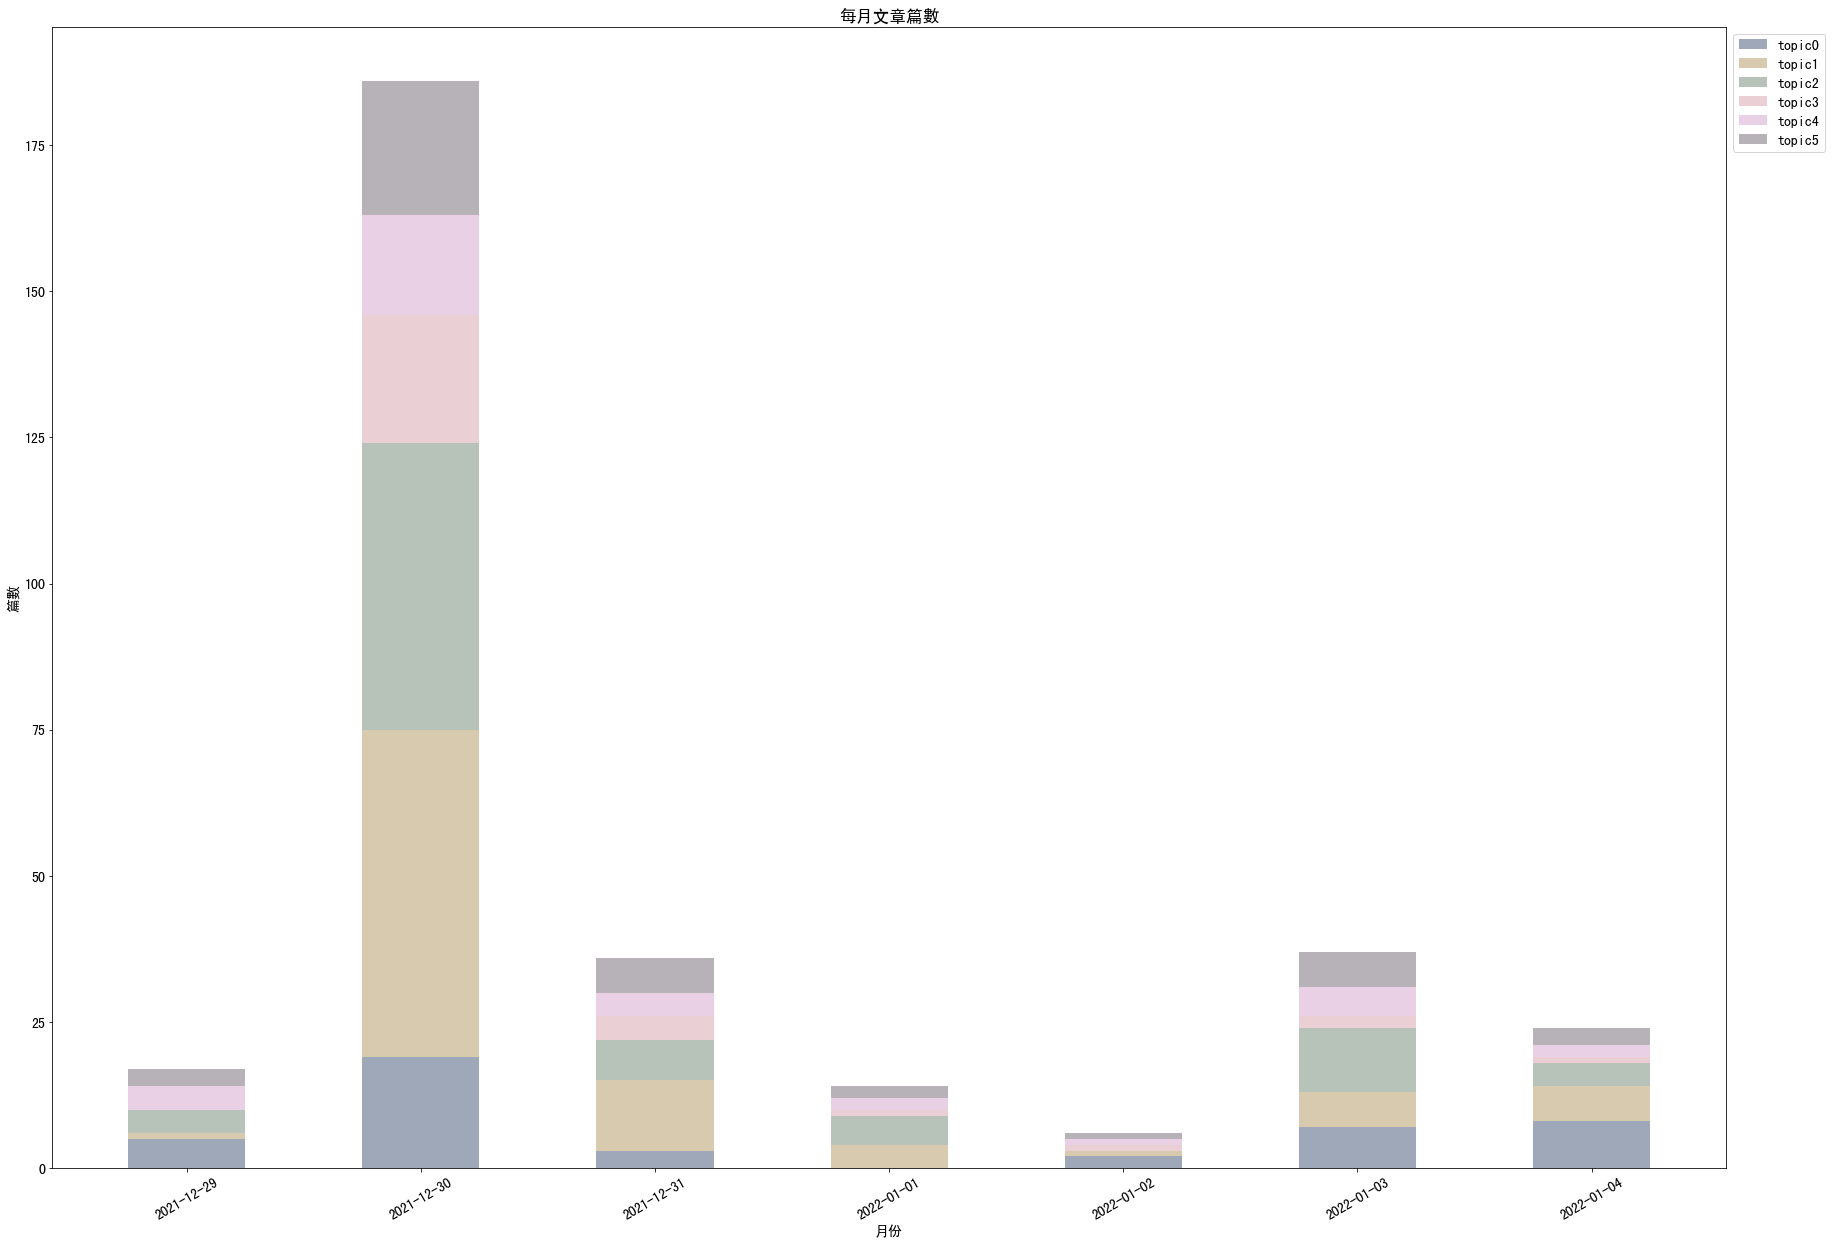

In [58]:
plt.subplots(figsize=(30, 21))
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5","#EAD0E5","#B7B2B8"]
column = ['topic0', 'topic1', 'topic2', 'topic3','topic4','topic5']
temp_bottom = 0

for i in range(0,6):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=0.5)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

- 看一下各主題在幹嘛

In [59]:
## 主題一
MetaData[MetaData['topic'] == 0].sample(n=3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
318,[情報]0104八大公股銀行買賣超排行,2022-01-04,11:44:14,https://www.ptt.cc/bbs/Stock/M.1641296657.A.B9...,addy7533967,Stock,70,47,2,"手機介面圖片好讀版：,,以下資訊依張數排列,買超 ...",0
26,[問卦]長榮是不是比gg工程師輕鬆又相對好賺？,2021-12-30,03:39:16,https://www.ptt.cc/bbs/Gossiping/M.1640835560....,KZS,Gossiping,45,14,3,"如題,,長榮一般專員月薪算四萬好了 ,*, 就,左右,加上年終,個月 大概,萬,,所以 長榮...",0
223,[心得]我與陽明糾結的2021,2021-12-29,02:57:44,https://www.ptt.cc/bbs/Stock/M.1640746666.A.C1...,JC1984,Stock,82,64,1,"好久沒發文了，,,對我來說是充滿刺激的一年，,還記得,決定把保險全部解約投入股市，,也在年初...",0


In [60]:
## 主題二
MetaData[MetaData['topic'] == 1].sample(n=3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
171,[問卦]101的LED廣告牆是不是沒錢了,2021-12-31,15:04:18,https://www.ptt.cc/bbs/Gossiping/M.1640963060....,soy5566,Gossiping,13,6,0,"如題 先來張照,,,,跨年場次的廣告費用屁眼想都知道超貴,,陽明爸爸的廣告也變成這種戰損版,...",1
20,[問卦]長榮套牢的現在還好嗎？,2021-12-30,03:14:41,https://www.ptt.cc/bbs/Gossiping/M.1640834084....,thelittleone,Gossiping,18,3,3,"女口是頁,,今天一早看,,發現長榮對員工發了大禮包,,這的確是很該鼓勵的行爲,,畢竟公司賺錢...",1
30,[問卦]後幾年去哪個產業年終能40個月？,2021-12-30,03:47:27,https://www.ptt.cc/bbs/Gossiping/M.1640836049....,TomFord5566,Gossiping,13,3,0,"以前聽到人家在長榮海運工作根本無感,,,今天看到,個月年終的瞬間變的令人稱羨的工作,,,不過...",1


In [61]:
## 主題三
MetaData[MetaData['topic'] == 2].sample(n=3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,"以前有幹過,個月保全來講一下,,我那時候的薪資單，機動的話錢會再多一點,,管委會一個月給多少...",2
150,Re:[新聞]獨/陽明海運員工年終獎金8個月有望在元,2021-12-30,20:00:24,https://www.ptt.cc/bbs/Gossiping/M.1640894426....,YU0486,Gossiping,1,0,1,"萬開頭那間呢,,這間我印象中比較蕩生,,起薪給超低,,不知道這間年終會給多少,,大家覺得呢？...",2
253,[新聞]陽明員工「望長榮興嘆」年終最高才領8,2021-12-30,08:39:39,https://www.ptt.cc/bbs/Stock/M.1640853581.A.8B...,lulu1305174,Stock,137,76,17,"原文標題：陽明員工「望長榮興嘆」 年終最高才領,個月：爛透了！,(請勿刪減原文標題),原文連...",2


In [62]:
## 主題四
MetaData[MetaData['topic'] == 3].sample(n=3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
11,[問卦]猴子下山來點名，萬海陽明給多少？,2021-12-30,02:13:58,https://www.ptt.cc/bbs/Gossiping/M.1640830440....,iPadProPlus,Gossiping,16,9,0,"安安 欸 幹,,長榮,個月,,那萬海陽明靜悄悄是？,,不敢說？,,不發給員工？有內部人有消息...",3
120,[問卦]八卦版整天說低薪,2021-12-30,11:30:56,https://www.ptt.cc/bbs/Gossiping/M.1640863858....,demandlonely,Gossiping,25,7,5,"整天說低薪 其實是假議題吧,說要給,好看,結果公投出來四個不同意完封,說人民苦及所苦,結果今...",3
123,[問卦]是不是只有我今年還沒買房買車？,2021-12-30,12:08:30,https://www.ptt.cc/bbs/Gossiping/M.1640866112....,eggman255,Gossiping,8,1,1,",年 看來不是只有長榮 ,個月最賺錢,,各大,不是買房買車 就是升級工作室,,,是不是只有我...",3


In [63]:
## 主題五
MetaData[MetaData['topic'] == 4].sample(n=3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
136,Re:[問卦]如何反駁，洋男屌打八卦台男,2021-12-30,13:40:25,https://www.ptt.cc/bbs/Gossiping/M.1640871628....,qaz90427,Gossiping,3,1,0,"血統贏了 就贏了,,努力只是浪費力氣,,有血輪眼 就是比較屌,,看到喜歡的台妹 今天跟...",4
90,Re:[問卦]長榮陽明484升官發財請走別路的例證,2021-12-30,07:12:16,https://www.ptt.cc/bbs/Gossiping/M.1640848338....,zalora,Gossiping,8,1,6,"其實第一志願海大輪機系分數並不高,,還原分數五科只要,就能上,,這分數如果去填電機系,,大概...",4
236,Re:[新聞]陽明私募股69.74萬張元月3日開始公開發,2021-12-30,00:23:55,https://www.ptt.cc/bbs/Stock/M.1640823837.A.D0...,iio,Stock,80,49,10,"有人寄信 幫忙代,,,,. 陽明這,萬張可以在,/,開始正常買賣的股票其中國發會基金接近,萬...",4


In [64]:
## 主題六
MetaData[MetaData['topic'] == 5].sample(n=3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
138,[問卦]華納HBOGO和迪士尼Disney+都幾？,2021-12-30,13:48:53,https://www.ptt.cc/bbs/Gossiping/M.1640872135....,terumikami,Gossiping,9,4,1,"華納兄弟和華特迪士尼,這兩家基本上應該算全球前兩大的影音媒體公司,公司有錢有豐富片單也有很多...",5
75,[新聞]行政院：19項新制元旦上路,2021-12-30,06:13:06,https://www.ptt.cc/bbs/Gossiping/M.1640844789....,Emerson158,Gossiping,18,7,2,",,,.:,,,,,.:,記者王敏旭／台北報導 , 分鐘前,,,.:,行政院：,項新制元旦...",5
6,Re:[新聞]超爽！長榮海運年終獎金落袋狂撒40個月,2021-12-30,01:30:45,https://www.ptt.cc/bbs/Gossiping/M.1640827847....,bebehome,Gossiping,8,3,0,",個月好像很多，我就問，一艘船上有幾個水手幾個貨櫃？,,,個月對照今年、明年航運盛況，九十牛...",5


### 6.5 判斷每筆發文的主題

**以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題**

In [65]:
data = MetaData.copy()

In [66]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:3])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.0005307125, 0.0005310514, 0.9973447, 0.0005307287, 0.00053065986, 0.00053217396], [0.00075262034, 0.00075394264, 0.0007553082, 0.0007518917, 0.00075186254, 0.99623436], [0.0004967997, 0.99751365, 0.00049760175, 0.0004964245, 0.00049870677, 0.0004967842]]


In [67]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [68]:
data[["artTitle","topic"]].head(5)

,artTitle,topic
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2
1,[新聞]「沒台灣，世界會停止運轉！」她列超狂5,5
2,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5,1
3,[新聞]超爽！長榮海運年終獎金落袋狂撒40個月,1
4,[問卦]你各位年終幾個月,1


###  6.6 資料內容探索
**查看兩個主題(3&2)的內容**

In [69]:
data[(data["topic"]==3)&(data["artTitle"].str.contains("長榮"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
95,[新聞]長榮40個月年終得繳多少稅？會計師估18萬,3
19,Re:[問卦]長榮發那麼多個月是不是很笨?,3
85,[問卦]長榮是不是發太少？,3
149,[問卦]長榮海把員工當什麼？,3
38,[問卦]長榮海運還有人要離職嗎？？,3


In [70]:
data[(data["topic"]==2)&(data["artTitle"].str.contains("長榮"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
247,[新聞]長榮海運發40個月年終！高層揭原因,2
43,[問卦]長榮海員工遇到王品員工說什麼？,2
278,[新聞]長榮超狂年終有所本！SCFI封關飆破5000點,2
17,[問卦]去年退休的長榮員工在想甚麼?,2
74,Re:[問卦]長榮今天要訂什麼下午茶？,2


## 7.基本圖學

In [71]:
data1 = MetaData.copy()

In [72]:
print(f"共有 {data1.shape[0]} 篇文章") #(row,column)
data1.head(3)

共有 320 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,"以前有幹過,個月保全來講一下,,我那時候的薪資單，機動的話錢會再多一點,,管委會一個月給多少...",2
1,[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021-12-29,15:01:11,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,Aliensoul,Gossiping,321,48,142,",.:,,雲,,,.:,記者曾筠淇／,,,.:,「沒台灣，世界會停止運轉！」她列超狂,實例網...",5
2,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021-12-29,17:26:21,https://www.ptt.cc/bbs/Gossiping/M.1640798784....,gourmand,Gossiping,26,6,1,"每次看到這個財經什麼美的出來講長榮就有氣,,講得有道理或符應後續事實發展也就算了,但偏偏經常...",1


In [73]:
def getToken(row):    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [74]:
data1['sentence'] = pd.DataFrame(data1['sentence'].astype(str))

In [75]:
# 匯入長榮檔案
names = []

with open(f'./dict/長榮.txt','r', encoding='UTF-8') as f:
    names = f.read().splitlines() #移除換行符號\n

In [76]:
word_df = data1.assign(word = data1['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
word_df

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,topic,word
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,2,以前
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,2,有
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,2,幹過
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,2,","
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,2,個
...,...,...,...,...,...,...,...,...,...,...,...
319,[情報]111年01月04日信用交易統計,2022-01-04,13:43:54,https://www.ptt.cc/bbs/Stock/M.1641303837.A.2F...,steward135,Stock,38,23,1,5,","
319,[情報]111年01月04日信用交易統計,2022-01-04,13:43:54,https://www.ptt.cc/bbs/Stock/M.1641303837.A.2F...,steward135,Stock,38,23,1,5,
319,[情報]111年01月04日信用交易統計,2022-01-04,13:43:54,https://www.ptt.cc/bbs/Stock/M.1641303837.A.2F...,steward135,Stock,38,23,1,5,
319,[情報]111年01月04日信用交易統計,2022-01-04,13:43:54,https://www.ptt.cc/bbs/Stock/M.1641303837.A.2F...,steward135,Stock,38,23,1,5,


In [77]:
# 篩選有在人物名稱裡的
word_df = word_df[(word_df['word'].isin(names) == True)]
word_df

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,topic,word
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,2,長榮
1,[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021-12-29,15:01:11,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,Aliensoul,Gossiping,321,48,142,5,長榮海運
1,[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021-12-29,15:01:11,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,Aliensoul,Gossiping,321,48,142,5,長榮
1,[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021-12-29,15:01:11,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,Aliensoul,Gossiping,321,48,142,5,長榮海運
1,[新聞]「沒台灣，世界會停止運轉！」她列超狂5,2021-12-29,15:01:11,https://www.ptt.cc/bbs/Gossiping/M.1640790075....,Aliensoul,Gossiping,321,48,142,5,長榮
...,...,...,...,...,...,...,...,...,...,...,...
314,[請益]年終：大方長榮vs.小氣陽明,2022-01-04,10:12:01,https://www.ptt.cc/bbs/Stock/M.1641291123.A.EA...,enouch777,Stock,22,10,3,1,長榮
317,Re:[新聞]長榮海運40個月年終奬金的背後…,2022-01-04,10:54:58,https://www.ptt.cc/bbs/Stock/M.1641293700.A.61...,c98765432c,Stock,18,2,15,1,長榮
317,Re:[新聞]長榮海運40個月年終奬金的背後…,2022-01-04,10:54:58,https://www.ptt.cc/bbs/Stock/M.1641293700.A.61...,c98765432c,Stock,18,2,15,1,萬海
318,[情報]0104八大公股銀行買賣超排行,2022-01-04,11:44:14,https://www.ptt.cc/bbs/Stock/M.1641296657.A.B9...,addy7533967,Stock,70,47,2,0,陽明


In [78]:
word_df = word_df.assign(count = 1)
word_token = word_df.groupby(['artTitle','word'])[['count']].sum().reset_index().sort_values('count', ascending=False)
word_token = word_token[ word_token['count'] > 1] #篩掉=1的
word_token

,artTitle,word,count
364,[新聞]長榮超級年終逾5成來自大陸,長榮,33
300,[新聞]獨家｜萬海年終還沒發分紅卻先打6折員,萬海,21
347,[新聞]長榮海運多數員工都領到40個月 陽明加紅,陽明,20
24,Re:[新聞]「沒台灣，世界會停止運轉！」她列超狂5,長榮,18
342,[新聞]長榮海運40個月年終奬金的背後…,長榮,18
...,...,...,...
29,Re:[新聞]樂極生悲傳秀出年終獎金的長榮員工被記,長榮,2
28,Re:[新聞]年終縮水員工氣炸陽明無奈：衝突對業務,陽明,2
39,Re:[新聞]陽明前3季賺逾千億8個月年終掀勞資對立,長榮海運,2
399,[請益]海運公司買廣告的效益是什麼？,陽明,2


In [79]:
word_pairs = word_token.copy()
perms = word_pairs.groupby('artTitle')['word'].apply(lambda s: pd.DataFrame(permutations(s, 2), columns=['term1', 'term2'])).reset_index()
perms = perms.drop('level_1', axis=1)
perms.head()

,artTitle,term1,term2
0,Fw:[新聞]望長榮年終興嘆，陽明員工爆最高才8個月,陽明,長榮
1,Fw:[新聞]望長榮年終興嘆，陽明員工爆最高才8個月,長榮,陽明
2,Fw:[新聞]狂發40月年終！長榮海運應徵中「職缺大,長榮海運,長榮
3,Fw:[新聞]狂發40月年終！長榮海運應徵中「職缺大,長榮,長榮海運
4,Fw:[新聞]長榮夫妻檔一早被錢砸醒：灌進500萬年終,長榮,長榮海運


In [80]:
word_pair = perms.copy()
word_pair['n'] = 1
word_pair = word_pair.groupby(['term1','term2'])[['n']].sum().reset_index()
word_pair = word_pair.sort_values('n', ascending=False).reset_index().drop('index', axis=1)
word_pair.head()

,term1,term2,n
0,陽明,長榮,28
1,長榮,陽明,28
2,長榮海運,長榮,20
3,長榮,長榮海運,20
4,萬海,長榮,11


In [81]:
word_pair = word_pair[word_pair.index % 2 == 1]
word_pair

,term1,term2,n
1,長榮,陽明,28
3,長榮,長榮海運,20
5,長榮,萬海,11
7,陽明,萬海,10
9,長榮海運,陽明,9
11,陽明海運,陽明,7
13,萬海,長榮海運,6
15,長榮,陽明海運,4
17,陽明海運,長榮海運,4
19,萬海,陽明海運,1


### 7.1 計算人物間Correlation

+ 斜對角(自己&自己)：correlation = 1
+ 上半部跟下半部會一樣

In [82]:
artTitle_word = pd.crosstab(word_pairs.artTitle, word_pairs.word)
word_cor = artTitle_word.copy()
word_cor = word_cor.reset_index()
correlation = word_cor.corr(method='pearson')
correlation

word,萬海,萬海航運,長榮,長榮海運,陽明,陽明海運
word,,,,,,
萬海,1.000000,0.241825,0.024600,0.122714,0.166911,-0.004413
萬海航運,0.241825,1.000000,-0.144561,-0.055641,-0.085090,-0.025609
長榮,0.024600,-0.144561,1.000000,-0.049056,-0.330261,-0.122444
長榮海運,0.122714,-0.055641,-0.049056,1.000000,-0.181642,0.148907
陽明,0.166911,-0.085090,-0.330261,-0.181642,1.000000,0.232295
陽明海運,-0.004413,-0.025609,-0.122444,0.148907,0.232295,1.000000


In [83]:
correlation.index.name = 'term1'
correlation = correlation.reset_index()
tidy = pd.DataFrame()
tidy = pd.melt(correlation, id_vars='term1', var_name='term2', value_name='correlation')
tidy

,term1,term2,correlation
0,萬海,萬海,1.000000
1,萬海航運,萬海,0.241825
2,長榮,萬海,0.024600
3,長榮海運,萬海,0.122714
4,陽明,萬海,0.166911
5,陽明海運,萬海,-0.004413
6,萬海,萬海航運,0.241825
7,萬海航運,萬海航運,1.000000
8,長榮,萬海航運,-0.144561
9,長榮海運,萬海航運,-0.055641


In [84]:
tidy = tidy.sort_values('correlation', ascending=False)
tidy = tidy[ tidy['term1'] != 'artTitle']
tidy = tidy[ tidy['term2'] != 'artTitle']
tidy = tidy[ tidy['term1'] != tidy['term2']] 
tidy

,term1,term2,correlation
6,萬海,萬海航運,0.241825
1,萬海航運,萬海,0.241825
34,陽明,陽明海運,0.232295
29,陽明海運,陽明,0.232295
4,陽明,萬海,0.166911
24,萬海,陽明,0.166911
33,長榮海運,陽明海運,0.148907
23,陽明海運,長榮海運,0.148907
3,長榮海運,萬海,0.122714
18,萬海,長榮海運,0.122714


## 7.2 建立Network

### 7.2.1 畫出人物關聯性社群網路圖

In [85]:
point_five = tidy[tidy['correlation']>0]
point_five.set_index = ('term1')
point_five

,term1,term2,correlation
6,萬海,萬海航運,0.241825
1,萬海航運,萬海,0.241825
34,陽明,陽明海運,0.232295
29,陽明海運,陽明,0.232295
4,陽明,萬海,0.166911
24,萬海,陽明,0.166911
33,長榮海運,陽明海運,0.148907
23,陽明海運,長榮海運,0.148907
3,長榮海運,萬海,0.122714
18,萬海,長榮海運,0.122714


In [86]:
five_net = Network(height='750px', width='100%', bgcolor='#ffffff', font_color='black') #設定

sources = point_five['term1']
targets = point_five['term2']
weights = point_five['correlation']

edge_data = zip(sources, targets, weights)
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]*10

    five_net.add_node(src, src, title=src)
    five_net.add_node(dst, dst, title=dst)
    five_net.add_edge(src, dst, value=w)

neighbor_map = five_net.get_adj_list()

for node in five_net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

five_net.show('five_net.html')
IPython.display.HTML(filename="./five_net.html")

# 8. 社群網路分析

###  8.1 基本網路圖

In [87]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

In [88]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic,cmtPoster,cmtStatus,cmtContent,cmtContent
0,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,"以前有幹過,個月保全來講一下,,我那時候的薪資單，機動的話錢會再多一點,,管委會一個月給多少...",2,maltum,推,:都是機歪人才在搞機歪事,:都是機歪人才在搞機歪事
1,Re:[新聞]大樓保全「是21歲年輕人」網見月薪全懂了,2021-12-29,14:34:20,https://www.ptt.cc/bbs/Gossiping/M.1640788462....,hn9480412,Gossiping,11,7,0,"以前有幹過,個月保全來講一下,,我那時候的薪資單，機動的話錢會再多一點,,管委會一個月給多少...",2,Swando,→,:知道會一直換的，還會標是想賭一把？,:知道會一直換的，還會標是想賭一把？


In [89]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(5)

,cmtPoster,artPoster,artUrl
0,maltum,hn9480412,https://www.ptt.cc/bbs/Gossiping/M.1640788462....
1,Swando,hn9480412,https://www.ptt.cc/bbs/Gossiping/M.1640788462....
2,zeumax,hn9480412,https://www.ptt.cc/bbs/Gossiping/M.1640788462....
3,zeumax,hn9480412,https://www.ptt.cc/bbs/Gossiping/M.1640788462....
4,kch0520,hn9480412,https://www.ptt.cc/bbs/Gossiping/M.1640788462....


In [90]:
len(link)

21033

In [91]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])
    

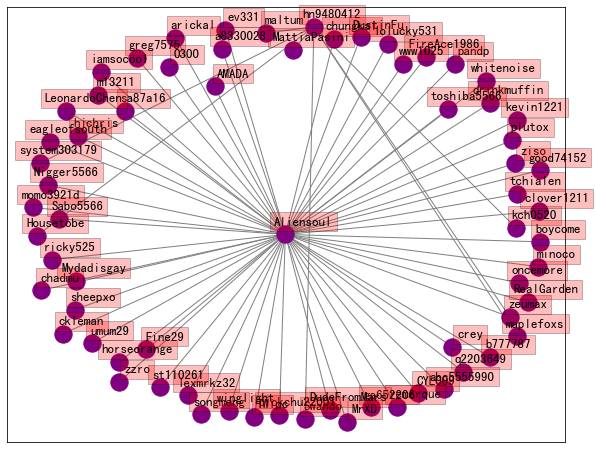

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

資料太多太雜(21033筆資料)，所以我們下面需要做進一步篩選

### 8.2 資料篩選

資料篩選的方式：

- 文章:文章日期、留言數(commentNum)
- link、node:degree

看一下文章留言數大概都多少(方便後面篩選)

Text(0, 0.5, 'count')

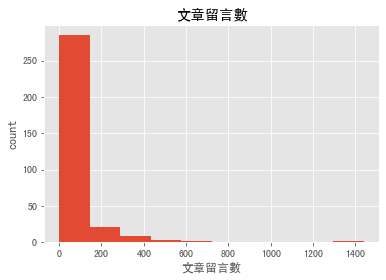

In [93]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei']  #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

In [94]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
146,justin531xx,9
218,shuweition,8
80,c98765432c,4
85,chean1020,4
228,steveisaman,4
...,...,...
103,dohmoto,1
104,eggman255,1
105,enouch777,1
106,epson5566,1


In [95]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 261
回覆者數量總共: 6637


**標記所有出現過的使用者**
- poster：只發過文、發過文+留過言
- replyer：只留過言

In [96]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [97]:
allPoster = pd.DataFrame(list(s),columns=["user"])
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replayer")
allPoster.head(5)

,user,type
0,ZxoF,replayer
1,joe284305,replayer
2,betrayer,replayer
3,Marty,replayer
4,yoyo2037312,replayer


### 8.3 以日期篩選社群

事件在12/30被討論次數最多，我們挑出當天的文章和回覆

In [98]:
# 篩選日期為2021-12-30 且 留言數>10的
posts_Reviews_1230 = (posts_Reviews.query('artDate == "2021-12-30"')
                      .query('commentNum>10')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [99]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_1230 = posts_Reviews_1230.query('size>3')
posts_Reviews_1230.head(3)

,cmtPoster,artUrl,size
14,AATC2,https://www.ptt.cc/bbs/Salary/M.1640873716.A.2...,4
33,ARKUE,https://www.ptt.cc/bbs/Stock/M.1640843440.A.C7...,6
58,AirLee,https://www.ptt.cc/bbs/Stock/M.1640879868.A.EC...,4


In [100]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1230 = pd.merge(posts_Reviews_1230,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1230.reset_index(inplace=True, drop=True) #重設index
link_1230.head(3)

,cmtPoster,artUrl,size,artPoster
0,AATC2,https://www.ptt.cc/bbs/Salary/M.1640873716.A.2...,4,zxc052630489
1,ARKUE,https://www.ptt.cc/bbs/Stock/M.1640843440.A.C7...,6,hyscout
2,AirLee,https://www.ptt.cc/bbs/Stock/M.1640879868.A.EC...,4,luckyturtle


In [101]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_1230)):
    G.add_edge(link_1230["cmtPoster"][i], link_1230["artPoster"][i])

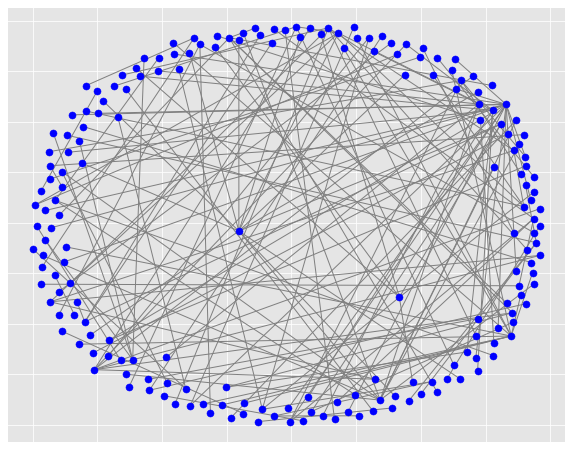

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

## 8.4 加上nodes的顯示資訊  
用使用者的身份來區分點的顏色
- poster:red(有發文)
- replyer:blue(只有回覆文章)

In [103]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

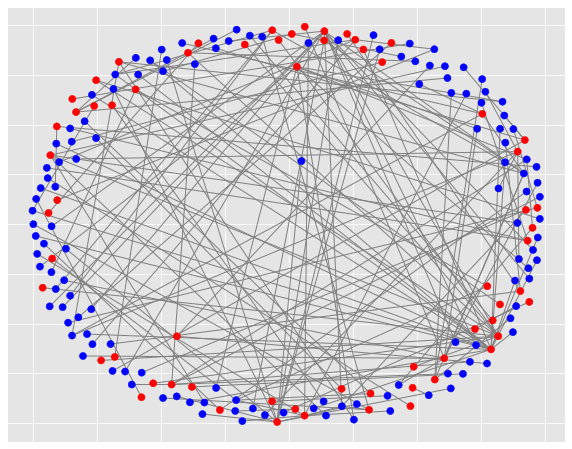

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

In [105]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [106]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [107]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>3]
degrees

['luckyturtle',
 'awhat',
 'BarryDale',
 'hiyato994',
 'chean1020',
 'klcs50304',
 'robin5339']

In [108]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

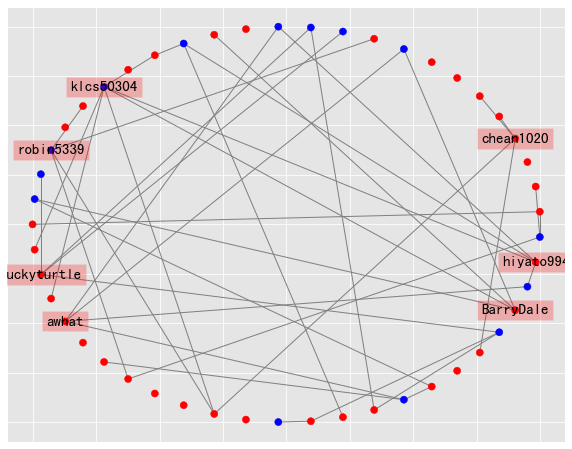

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
# pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=15,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

In [110]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'zxc052630489': 0.020833333333333332,
 'hyscout': 0.020833333333333332,
 'luckyturtle': 0.125,
 'copybrown': 0.020833333333333332,
 'awhat': 0.08333333333333333,
 'centaurjr': 0.0,
 'ddd852': 0.020833333333333332,
 'luxuryer': 0.041666666666666664,
 'aiglas0209': 0.0,
 'Iplay136259': 0.041666666666666664,
 'kenbo': 0.0625,
 'Vitaceae': 0.0,
 'KJC1004': 0.020833333333333332,
 'owem777': 0.041666666666666664,
 'justin531xx': 0.020833333333333332,
 'snsd9': 0.041666666666666664,
 'Mazu323': 0.0625,
 'dohmoto': 0.041666666666666664,
 'lmfao': 0.0,
 'pat740515': 0.020833333333333332,
 'andy310082': 0.0625,
 'BarryDale': 0.08333333333333333,
 'bndan': 0.041666666666666664,
 'hiyato994': 0.08333333333333333,
 'bruce20053': 0.0625,
 'daisybubble': 0.041666666666666664,
 'ihl123456': 0.020833333333333332,
 'klm': 0.0,
 'chean1020': 0.08333333333333333,
 'cena0605': 0.020833333333333332,
 'thelittleone': 0.020833333333333332,
 'KobeNi': 0.0,
 'lulu1305174': 0.0,
 'fbtm': 0.041666666666666664,
 

In [111]:
# eigenvector centrality
#eigenvector = nx.eigenvector_centrality(G)
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)
# betweenness centrality
between = nx.betweenness_centrality(G)

In [112]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
#print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['luckyturtle', 'klcs50304', 'awhat', 'BarryDale', 'hiyato994']
pagerank centrality: ['klcs50304', 'luckyturtle', 'chean1020', 'robin5339', 'BarryDale']
betweenness centrality: ['klcs50304', 'kenbo', 'robin5339', 'BarryDale', 'luxuryer']


### 8.4.1 以主題篩選社群

挑選出2021-12-30當天的文章， 篩選一篇文章回覆2次以上者，且文章留言數大於10則， 文章主題歸類為0(報導相關)與2(調侃)者， 欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [113]:
# 加上topic
topic_1230 = pd.merge(link_1230,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [114]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1230_topic = pd.merge(topic_1230,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1230_topic.reset_index(inplace=True, drop=True) #重設index
link_1230_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,AATC2,https://www.ptt.cc/bbs/Salary/M.1640873716.A.2...,0,zxc052630489
1,ARKUE,https://www.ptt.cc/bbs/Stock/M.1640843440.A.C7...,2,hyscout
2,AirLee,https://www.ptt.cc/bbs/Stock/M.1640879868.A.EC...,1,luckyturtle


In [115]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0,len(link_1230_topic)):
    G.add_edge(link_1230_topic["cmtPoster"][i], link_1230_topic["artPoster"][i])
    if link_1230_topic["topic"][i] == 3: #以主題區分顏色
        color_map_edge.append('orange') # 主題三:長榮年終與獎金
    else: 
        color_map_edge.append('grey') # 主題四:長榮、陽明、萬海員工比較輿論

In [116]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [117]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [118]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

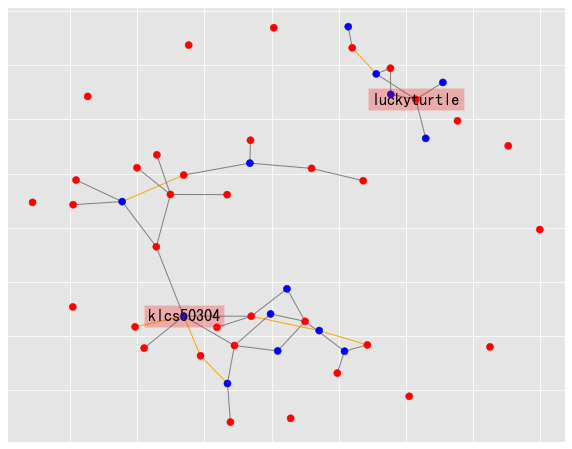

In [119]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

- luckyturtle多講述長榮年終與獎金 ， lkcs0304多講述長榮、陽明、萬海員工的比較～

### 8.4.2 使用者是否受到歡迎

PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓就好，因此把箭頭清掉。

In [120]:
# 加上status
status_1230 = pd.merge(link_1230,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_1230 = status_1230[status_1230["cmtStatus"]!="→"]

In [121]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1230_status = pd.merge(status_1230,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1230_status.reset_index(inplace=True, drop=True) #重設index
link_1230_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,AATC2,https://www.ptt.cc/bbs/Salary/M.1640873716.A.2...,0,推,zxc052630489
1,ARKUE,https://www.ptt.cc/bbs/Stock/M.1640843440.A.C7...,2,噓,hyscout
2,AirLee,https://www.ptt.cc/bbs/Stock/M.1640879868.A.EC...,1,推,luckyturtle


In [122]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_1230_status)):
    G.add_edge(link_1230_status["cmtPoster"][i], link_1230_status["artPoster"][i])
    if link_1230_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')    

In [123]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [124]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [125]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

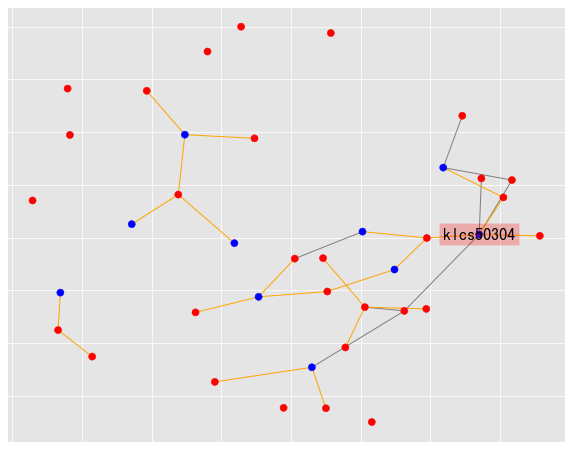

In [126]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

### 8.4.3 結論 

+ 可以發現本次的討論中推文、噓文差不多。